**Project- Fire and smoke detection**

**step1- Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras import utils  # to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/ Deep Learning Projects/ fire and smoke detection")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Step 2 **Define the constants**

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
filenames = os.listdir("/content/drive/MyDrive/ Deep Learning Projects/ fire and smoke detection/Fire")
categories = []

for filename in filenames:
    category = filename.split('.') [0] #
    if category == 'Fire':
      categories.append(1)

    else:
      categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


In [ ]:
df.head()

,filename,category
0,77.jpg,0
1,19.jpg,0
2,57.jpg,0
3,130.jpg,0
4,38.jpg,0


In [ ]:
df.tail()

,filename,category
196,54.jpg,0
197,87.jpg,0
198,48.jpg,0
199,166.jpg,0
200,40.jpg,0


<Axes: xlabel='category'>

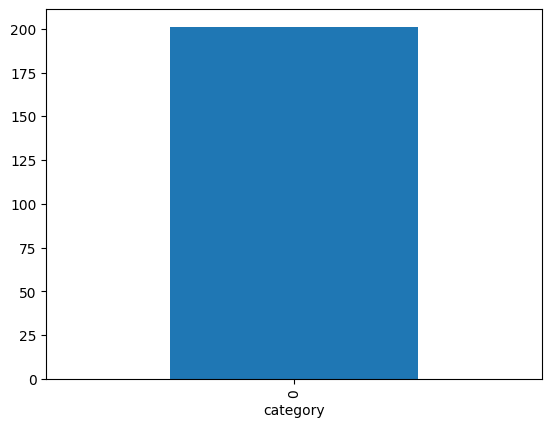

In [ ]:
df['category'].value_counts().plot.bar()

**See sample image**

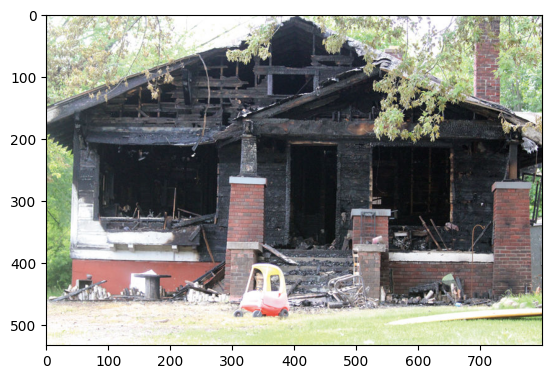

In [ ]:
sample = random.choice(filenames)
image = load_img ("/content/drive/MyDrive/ Deep Learning Projects/ fire and smoke detection/Fire/" +sample)
plt.imshow(image)

Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.

Conv Layer: This layer will extract features from image.

Pooling Layer: This layerreduce the spatial volume of input image after convolution.

Fully Connected Layer: It connect the network from a layer to another layer Output Layer: It is the predicted values layer.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes


model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

**Prepare data**

Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to smoke and 0 to Fire

In [ ]:
df["category"] = df["category"].replace({0:'Fire',1:'Smoke'})

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80% train, 20% validation)

train_df,validate_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df['category'])

# Reset the index for both dataframes
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

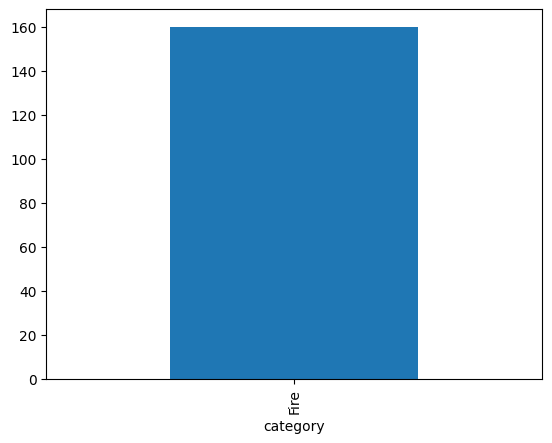

In [ ]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

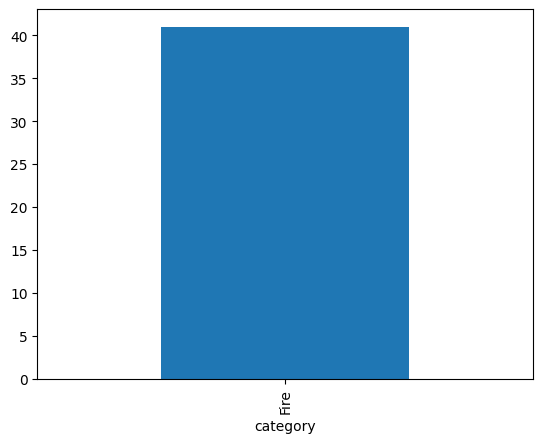

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
validate_df.shape

(41, 2)

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size= 15

**Training** **Generator**

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    rescale=1./255  # Normalize pixel values
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/drive/MyDrive/ Deep Learning Projects/ fire and smoke detection/Fire",
    x_col= "filename",
    y_col="category",
    target_size =IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size


)






Found 160 validated image filenames belonging to 1 classes.


**Validation Generator**

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/drive/MyDrive/ Deep Learning Projects/ fire and smoke detection/Fire",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)





Found 41 validated image filenames belonging to 1 classes.


See how our generator work

In [ ]:
example_df=train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/drive/MyDrive/ Deep Learning Projects/ fire and smoke detection/Fire/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


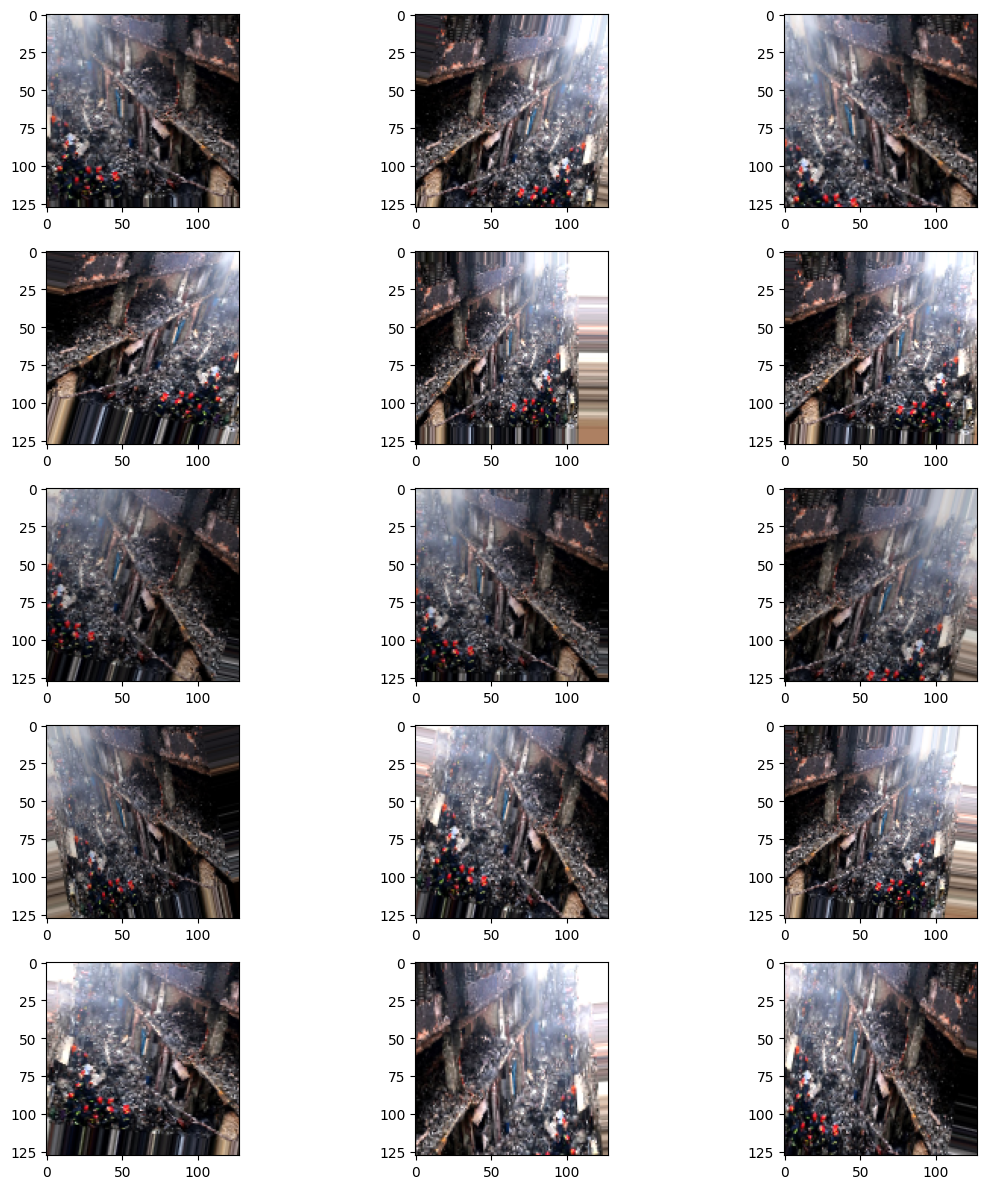

In [ ]:
plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for X_batch,Y_batch in example_generator:
       image = X_batch[0]
       plt.imshow(image)
       break
plt.tight_layout()
plt.show()

**Fit Model**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model with the callback
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=[reduce_lr]
)

# Save the trained model
model.save("my_model_updated.keras")

Epoch 1/50
10/10 [==============================] - 9s 664ms/step - loss: 2.1476 - accuracy: 0.5655 - val_loss: 6.1437 - val_accuracy: 0.0333 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 5s 556ms/step - loss: 2.2152 - accuracy: 0.5241 - val_loss: 5.2570 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 7s 720ms/step - loss: 2.2102 - accuracy: 0.4690 - val_loss: 5.2115 - val_accuracy: 0.0333 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 7s 691ms/step - loss: 2.0560 - accuracy: 0.5034 - val_loss: 3.0347 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 5s 544ms/step - loss: 1.9790 - accuracy: 0.5103 - val_loss: 3.9024 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 8s 797ms/step - loss: 1.9044 - accuracy: 0.4621 - val_loss: 1.9851 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 7/50
10/10 [==============================] - 5s 549ms/step 

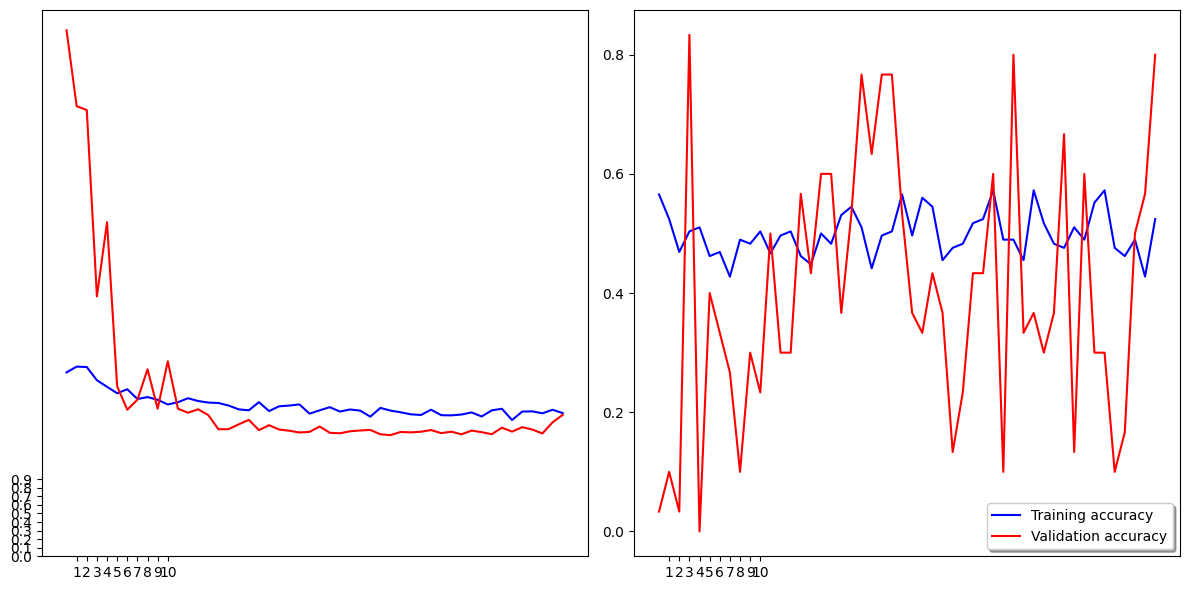

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 11, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 11, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

**Confusion matrix and Classificaton Report**

In [ ]:
# prediction
result = model.predict(validation_generator,batch_size = batch_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_test = validation_generator.labels

# Evaluvate
loss,acc = model.evaluate(validation_generator, batch_size = batch_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 82.92682766914368
The Loss of the model for testing data is: 1.6841360330581665


The model achieves an accuracy of 82.93% on the testing data, indicating its effectiveness in correctly classifying instances. However, with a loss of 1.68, there's room for improvement in minimizing errors during prediction. Overall, the model demonstrates a strong ability to generalize to unseen data, but further optimization may enhance its performance and reduce prediction errors.

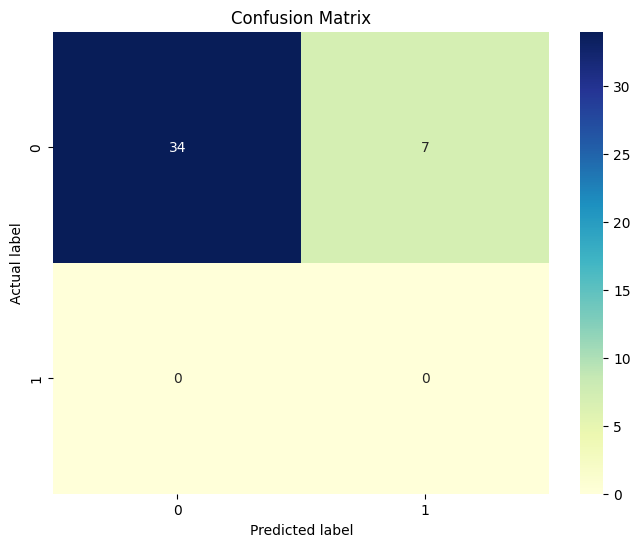

In [ ]:
 # Assuming you have defined y_test and y_pred earlier or from your model predictions

# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()






In [ ]:
# Calculate and print the Classification Report with zero_division parameter
from sklearn.metrics import classification_report

class_report = classification_report(y_test, y_pred, zero_division=1)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        41
           1       0.00      1.00      0.00         0

    accuracy                           0.83        41
   macro avg       0.50      0.91      0.45        41
weighted avg       1.00      0.83      0.91        41



1/1 [==============================] - 0s 341ms/step
Smoke


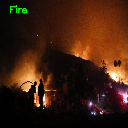

1/1 [==============================] - 0s 20ms/step
Smoke


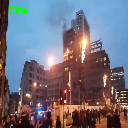

1/1 [==============================] - 0s 24ms/step
Smoke


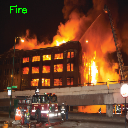

1/1 [==============================] - 0s 19ms/step
Smoke


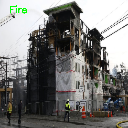

1/1 [==============================] - 0s 19ms/step
Smoke


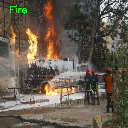

1/1 [==============================] - 0s 17ms/step
Smoke


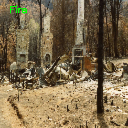

1/1 [==============================] - 0s 20ms/step
Smoke


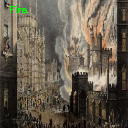

1/1 [==============================] - 0s 27ms/step
Smoke


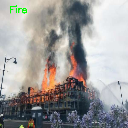

1/1 [==============================] - 0s 21ms/step
Smoke


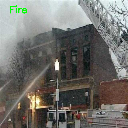

1/1 [==============================] - 0s 25ms/step
Smoke


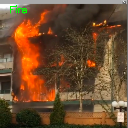

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import os
import random

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

for i in range(10):
    all_test_images = os.listdir('/content/drive/MyDrive/ Deep Learning Projects/ fire and smoke detection/output/testing')
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'/content/drive/MyDrive/ Deep Learning Projects/ fire and smoke detection/output/testing/{random_image}')
    img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))

    org = img.copy()
    img = img.reshape(1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)

    pred = model.predict(img)
    print(['Fire', 'Smoke'][int(pred[0][0])])
    cv2_imshow(org)
    cv2.waitKey(0)

cv2.destroyAllWindows()

In [ ]:
!pip install gradio==3.50

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.8 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=3664735d60aa8fe5be52bd765c5dc98834f3aa1dedf462a510745ec5e9f982a3

In [ ]:
from tensorflow.keras.models import load_model
import cv2
import gradio as gr

In [ ]:
from keras.models import load_model

# Specify the full path to the model file
model_path = "/content/drive/MyDrive/ Deep Learning Projects/ fire and smoke detection/my_model_updated.keras"
# Load the model using the full path
model = load_model(model_path)

In [ ]:
def predict(image):
    img = cv2.resize(image,(128,128))
    img = img.reshape(1,128,128,3)
    preds = model.predict(img)[0]
    result = dict()
    result["Fire"] = round(float(list(preds)[0]), 3)
    result["Smoke"] = round(float(list(preds)[1]), 3)

    return result

In [ ]:
import gradio as gr

# Define your predict function
def predict(image):
    # Perform prediction using your CNN model
    # Replace this comment with your actual prediction code
    prediction_result = "Your prediction here"

    return prediction_result

# Define the Gradio interface
im = gr.inputs.Image()
label = gr.outputs.Label(num_top_classes=2)

gr.Interface(fn=predict, inputs=im, outputs=label, title="CNN Demo").launch(share=True, debug=True)

Conclusion -The model shows excellent precision and high recall for class 0, driving its overall accuracy to 0.83. However, it struggles with class 1 predictions, resulting in zero precision. To achieve better balance, enhancements are necessary for identifying class 1 instances effectively.